In [28]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pandas as pd
from sklearn.model_selection import train_test_split
import time
from statistics import mean
import sklearn as sk
import warnings
from sklearn.utils import resample
import pickle as pickle

import PIL as pl
warnings.filterwarnings('ignore')

path = '/Users/sepehrbe/DataSources/Kaggle/SkinCare/Data/'
meta_data = 'Metadata.csv'
G_path = '/Volumes/GoogleDrive/My Drive/DataSources/SkinCare/'

# **Import Meta Data**

In [29]:
file = '/Users/sepehrbe/DataSources/Kaggle/SkinCare/Data/Metadata.csv'
meta_data_v0 = pd.read_csv(file)

In [30]:
meta_data_v0.isnull().any()

lesion_id       False
image_id        False
dx              False
dx_type         False
age              True
sex             False
localization    False
dtype: bool

In [6]:
for s in meta_data_v0.columns:
    print('#########   ', s , '     #########################')
    print(meta_data_v0[s].value_counts( dropna = False ))
    print('####################################################')

#########    lesion_id      #########################
HAM_0003789    6
HAM_0000835    6
HAM_0005263    6
HAM_0001863    6
HAM_0007427    5
              ..
HAM_0006000    1
HAM_0002762    1
HAM_0006894    1
HAM_0007132    1
HAM_0003347    1
Name: lesion_id, Length: 7470, dtype: int64
####################################################
#########    image_id      #########################
ISIC_0027419    1
ISIC_0030646    1
ISIC_0030164    1
ISIC_0032069    1
ISIC_0029007    1
               ..
ISIC_0028768    1
ISIC_0026383    1
ISIC_0025794    1
ISIC_0028888    1
ISIC_0032258    1
Name: image_id, Length: 10015, dtype: int64
####################################################
#########    dx      #########################
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: dx, dtype: int64
####################################################
#########    dx_type      #########################
histo        5340
follow_up    3704
conse

# **Filling NaN/Unkown Values**

In [34]:
meta_data = meta_data_v0.copy()
meta_data['age'].fillna(meta_data.groupby('sex')['age'].transform('mean'),inplace=True)
meta_data['sex'].replace('unknown',np.nan, inplace=True)
meta_data['sex'].fillna(meta_data.groupby('dx')['sex'].value_counts().index[0][1],inplace=True)

meta_data['localization'].replace('unknown',np.nan, inplace=True)
meta_data['localization'].fillna(meta_data.groupby(['dx','sex'])['localization'].value_counts().index[0][2],inplace=True)

In [33]:
meta_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           10015 non-null  float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
dtypes: float64(1), object(6)
memory usage: 547.8+ KB


In [8]:
for s in meta_data.columns:
    print('#########   ', s , '     #########################')
    print(meta_data[s].value_counts( dropna = False ))
    print('####################################################')

#########    lesion_id      #########################
HAM_0003789    6
HAM_0000835    6
HAM_0005263    6
HAM_0001863    6
HAM_0007427    5
              ..
HAM_0006000    1
HAM_0002762    1
HAM_0006894    1
HAM_0007132    1
HAM_0003347    1
Name: lesion_id, Length: 7470, dtype: int64
####################################################
#########    image_id      #########################
ISIC_0027419    1
ISIC_0030646    1
ISIC_0030164    1
ISIC_0032069    1
ISIC_0029007    1
               ..
ISIC_0028768    1
ISIC_0026383    1
ISIC_0025794    1
ISIC_0028888    1
ISIC_0032258    1
Name: image_id, Length: 10015, dtype: int64
####################################################
#########    dx      #########################
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: dx, dtype: int64
####################################################
#########    dx_type      #########################
histo        5340
follow_up    3704
conse

# **Import Images**

In [35]:
img_list = os.listdir(img_path)
HAM_DataSource = pd.DataFrame(columns=['image_id','img_array'])
for img in img_list:
    img_name = img.replace('.jpg','')
    image = pl.Image.open( img_path + img)
    img_array = np.asarray(image)
    new_row = pd.Series({'image_id':img_name,'img_array':img_array}, name='')
    HAM_DataSource = HAM_DataSource.append(new_row)

In [36]:
HAM_DataSource = HAM_DataSource.merge(meta_data, how="left",on='image_id').rename(columns={'dx':'image_label'})
HAM_DataSource.image_label = pd.Categorical(HAM_DataSource.image_label)
HAM_DataSource['label_id'] = HAM_DataSource.image_label.cat.codes

# **Balance DataSet**

In [11]:
df_class1 = resample(HAM_DataSource[HAM_DataSource.label_id==5], replace=True,   n_samples=1200, random_state=0) 
df_other_classes = HAM_DataSource[HAM_DataSource.label_id!=5]
HAM_DataSource_blc = pd.concat([df_other_classes,df_class1], axis=0)

In [12]:
HAM_DataSource_blc.label_id.value_counts()

5    1200
4    1113
2    1099
1     514
0     327
6     142
3     115
Name: label_id, dtype: int64

# **Remove Duplications**

In [13]:
HAM_DataSource_blc_noDup = HAM_DataSource_blc.groupby('lesion_id').first().reset_index()

In [14]:
HAM_DataSource_blc_noDup.label_id.value_counts()

5    1039
2     727
4     614
1     327
0     228
6      98
3      73
Name: label_id, dtype: int64

In [15]:
HAM_DataSource_blc_noDup.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3106 entries, 0 to 3105
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   lesion_id     3106 non-null   object  
 1   image_id      3106 non-null   object  
 2   img_array     3106 non-null   object  
 3   image_label   3106 non-null   category
 4   dx_type       3106 non-null   object  
 5   age           3106 non-null   float64 
 6   sex           3106 non-null   object  
 7   localization  3106 non-null   object  
 8   label_id      3106 non-null   int8    
dtypes: category(1), float64(1), int8(1), object(6)
memory usage: 176.4+ KB


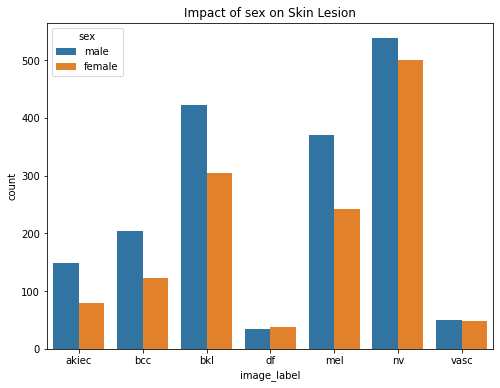

In [16]:
df_ = HAM_DataSource_blc_noDup
fig, ax=plt.subplots(figsize=(8,6))
sns.countplot(x='image_label', data=df_, hue='sex')
# ax.set_ylim(0,500)
plt.title("Impact of sex on Skin Lesion")
plt.show()

# **Functions**

In [17]:
def split_dataset(dataset, tst_ratio, valid_ratio):
    training_data, test_data = train_test_split(dataset, test_size = tst_ratio, random_state=0,stratify=dataset['label_id'])
    train_data, valid_data = train_test_split(training_data, test_size= valid_ratio, random_state=0,stratify=training_data['label_id'])
    train_data['type'] = 'train'
    valid_data['type'] = 'valid'
    test_data['type'] = 'test'
    dataset = pd.concat([train_data,valid_data,test_data],axis=0)
    return dataset

# **Split DataSet**

In [18]:
HAM_DataSource_blc = split_dataset(dataset = HAM_DataSource_blc , tst_ratio = 0.1, valid_ratio  = 0.1)
HAM_DataSource_blc_noDup = split_dataset(dataset = HAM_DataSource_blc_noDup , tst_ratio = 0.1, valid_ratio  = 0.1)

In [19]:
HAM_DataSource_blc[HAM_DataSource_blc.type=='train'].label_id.value_counts(normalize=True)

5    0.266083
4    0.246920
2    0.243635
1    0.114153
0    0.072269
6    0.031481
3    0.025459
Name: label_id, dtype: float64

In [20]:
HAM_DataSource_blc[HAM_DataSource_blc.type=='test'].label_id.value_counts(normalize=True)

5    0.266075
4    0.246120
2    0.243902
1    0.113082
0    0.073171
6    0.031042
3    0.026608
Name: label_id, dtype: float64

# **Standardization / Normalization**

In [21]:
def standardizaion(dataset, attr):
    mean = dataset[dataset.type.str.contains('train|valid')][attr].mean()
    std = dataset[dataset.type.str.contains('train|valid')][attr].std()
    dataset[attr] = (dataset[attr] - mean ) / std
    return dataset

In [22]:
def MinMaxScaling(dataset, attr):
    min = dataset[dataset.type.str.contains('train|valid')][attr].min()
    max = dataset[dataset.type.str.contains('train|valid')][attr].max()
    dataset[attr] = (dataset[attr] - min ) / (max-min)
    return dataset

In [23]:
# HAM_DataSource_blc_STD = standardizaion(HAM_DataSource_blc , 'age')
# HAM_DataSource_blc_noDup_STD = standardizaion(HAM_DataSource_blc_noDup , 'age')

# **Normalization**

In [24]:
HAM_DataSource_blc_STD = MinMaxScaling(HAM_DataSource_blc , 'age')
HAM_DataSource_blc_noDup_STD = MinMaxScaling(HAM_DataSource_blc_noDup , 'age')

In [25]:
HAM_DataSource_blc_STD['age']

1640    0.823529
6104    0.470588
8607    0.529412
9745    1.000000
2110    0.882353
          ...   
6008    0.647059
8295    0.529412
30      0.823529
8189    0.470588
2600    0.647059
Name: age, Length: 4510, dtype: float64

In [29]:
# pd.to_pickle(HAM_DataSource_blc_STD,G_path + 'DataSource_60x45_Red')
# pd.to_pickle(HAM_DataSource_blc_noDup_STD,G_path + 'DataSource_Red_noDup')

In [27]:
pickle.dump(HAM_DataSource_blc_STD, open(G_path + 'DataSource_60x45_Red', 'wb'))
pickle.dump(HAM_DataSource_blc_noDup_STD, open(G_path + 'DataSource_60x45_Red_noDup', 'wb'))

In [22]:
HAM_DataSource_blc_STD.type.value_counts()

train    3450
valid     609
test      451
Name: type, dtype: int64

In [41]:
pd.__version__

'1.4.2'

In [ ]:
pickle. ()